In [2]:
import json 
import numpy as np 
from tqdm import tqdm 
from pathlib import Path
from collections import defaultdict

def get_prediction(prob_dict_list):
    predicted_toks_and_probs = []
    for timestep, prob_dict in enumerate(prob_dict_list): 
        toks, probs = zip(*prob_dict.items())
        # print(prob_dict['SourceCopy'])
        best_prob_idx = np.argmax(probs)
        best_prob, best_tok = probs[best_prob_idx], toks[best_prob_idx]
        predicted_toks_and_probs.append((best_tok, best_prob))
    return predicted_toks_and_probs

def check_tokens(pred_tok, tgt_tok, prev_tgts):
    if "SourceCopy" not in pred_tok and "TargetCopy" not in pred_tok:
        return pred_tok == tgt_tok
    elif "SourceCopy" in pred_tok:
        return pred_tok.split("_")[1] == tgt_tok
    else:
        try:
            tok_idx = int(pred_tok.split("_")[1])-5
            return prev_tgts[tok_idx] == tgt_tok
        except IndexError:
            print(len(prev_tgts))
            print(pred_tok)
            print(prev_tgts)
            raise AssertionError
    

def read_json(path): 
    print(f"opening data")
    with open(path) as f1:
        data = json.load(f1)
    print(f"got data")
    return data

def get_probs(data):
    probs_to_ret = defaultdict(list)
    func_ontology = set()

    mistakes, corrects = [], []

    for instance in tqdm(data): 
        instance = instance
        left_context = [x[0] for x in instance['left_context']][1:]
        target_toks = left_context + ["@end@"]
        probs = instance['prob_dist']
        predicted_toks = get_prediction(probs)

        source_tokens = " ".join([x[0] for x in instance['source_tokens']])
        for i in range(len(left_context)):
            input_token = left_context[i]
            output_token = predicted_toks[i][0]
            output_prob = predicted_toks[i][1]
            target_token = target_toks[i]
            tokens_are_equal = check_tokens(output_token, target_token, left_context[:i])
            if not tokens_are_equal:
                mistake = {"source_tokens": source_tokens,
                           "left_context": left_context[0:i],
                           "target_toks": target_toks[0:i],
                           "output_token": output_token,
                           "output_prob": output_prob,
                           "target_token": target_token}
                mistakes.append(mistake)
            else:
                correct = {"source_tokens": source_tokens,
                           "left_context": left_context[0:i],
                           "target_toks": target_toks[0:i],
                           "output_token": output_token,
                           "output_prob": output_prob,
                           "target_token": target_token}
                corrects.append(correct)


    return mistakes, corrects

In [3]:
data = read_json("/brtx/604-nvme2/estengel/miso_models/tune_roberta//translate_output/dev_valid_losses.json")

opening data
got data


In [4]:
mistakes, corrects = get_probs(data)

100%|██████████| 6815/6815 [01:18<00:00, 86.65it/s] 


In [6]:
print(len(mistakes))
print(len(corrects))

2271
89518


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 



In [26]:
mistake_probs = [x['output_prob'] for x in mistakes]
correct_probs = [x['output_prob'] for x in corrects]


print(np.mean(mistake_probs))
print(np.mean(correct_probs))

# prob_df = pd.DataFrame(columns=['prob', 'correct'])
prob_df_data = []
for prob in mistake_probs:
    prob_df_data.append({'prob': prob, 'correct': False}) 
for prob in correct_probs:
    prob_df_data.append({'prob': prob, 'correct': True}) 


prob_df = pd.DataFrame(prob_df_data)




0.8095576212709037
0.9928329907630354


In [27]:
import scipy 
from collections import Counter

values, bin_edges, bin_number = scipy.stats.binned_statistic(prob_df['prob'], prob_df['correct'], statistic='mean', bins=20)
bin_lookup = Counter(bin_number)

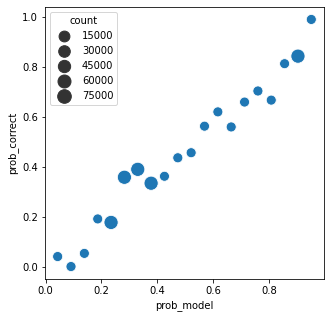

In [31]:
fig, ax = plt.subplots(figsize=(5,5))


df_to_plot = pd.DataFrame(columns=["prob_model", "prob_correct", "count"])
for val, edge, bin_num in zip(values, bin_edges, bin_number):
    df_to_plot = df_to_plot.append({"prob_model": edge, "prob_correct": val, "count": bin_lookup[bin_num]}, ignore_index=True)


sns.scatterplot(data=df_to_plot, x = "prob_model", y="prob_correct", size="count", sizes=(100, 200), ax=ax)